# Naive Bayes


## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model).

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, flatten each image to create a 1D array with 784 elements.



### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
```

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.


In [84]:
from sklearn.datasets import fetch_openml
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
newsgroups_data_train = fetch_20newsgroups(subset='train',remove= ('headers', 'footers', 'quotes'))
newsgroups_data_test = fetch_20newsgroups(subset='test',remove= ('headers', 'footers', 'quotes'))
from scipy.sparse import csr_matrix
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [85]:

# Fetch data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)


### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1
The parameters of the model are:
1. Prior , The probability of each digit(class) occuring: Calculated for each class by dividing the occurence of each class (sum(y[y==i]))  by the total number of labels len(y). Final equation will be [ sum(y[y==i]) / len(y)].
2. pixel-probability , the probability of each pixel being 1 or 0: We calculate the probability of each pixel  having value of 1, for each class,  by summing the number of times a specific pixel had the value 1 and divide it by the total number of that class occuring. p(pixel == 1) = sum(X[y==digit,pixel] ==1) / sum(y==digit), for each pixel in (0,784), for each digit in (0,9).

Probability of a pixel having value 0 is equal to 1 - p(digit==1).

Since the probability of an input belonging to a digit is calculated by : P(y=digit | x=input) = likelihood * prior
We can calculate the probability of a given input belonging to each class and choose the class with the maximal likelihood.

The classification rule is:<br>

$p(y  \mid  \mathbf{x}) = \> \frac{p( \mathbf{x}  \mid  y) p(y)}{p(\mathbf{x})}.$

Lets work on the nominator: 

$p( \mathbf{x}  \mid  y) = p(x_1  \mid y) \cdot p(x_2  \mid  x_1, y) \cdot ... \cdot p( x_i  \mid  x_1, ..., x_{i-1}, y).$

We can assume independence

$p(y  \mid  \mathbf{x}) =  p(y = j)\prod_{i=1}^d p(x_i  \mid  y = j).$

--------------------

Since we know: 

$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$

We can say:

$p(y  \mid  \mathbf{x}) = p(y = j) \prod_{i=1}^n p(x_i  \mid  y = j)^{x_i}(1 - p(x_i  \mid  y = j)^{1 - x_i}).$

-----------------------------

We want to estimate our model so we can use

$\hat{y} = \mathrm{argmax}_y \> p(y  \mid  \mathbf{x}) = \mathrm{argmax}_y \> \frac{p( \mathbf{x}  \mid  y) p(y)}{p(\mathbf{x})}.$

Since every multipication is divided by P(X) we can simplify our equation:

$\hat{y} = \mathrm{argmax}_y \> p(y  \mid  \mathbf{x}) = \mathrm{argmax}_y \> \ p( \mathbf{x}  \mid  y) p(y)$

---------------------------

But we can still have problem with probabilities zero (edge case), so we will use $\log$ which will also make our formula easier to work.

$\hat{y} = \mathrm{argmax}_y \> p(y  \mid  \mathbf{x}) = \log{p(y = j)} +  \sum_{i=1}^n x_i \log{p(x_i  \mid  y = j)} + \sum_{i=1}^n(1-x_i)\log{(1 - p(x_i  \mid  y = j))}.$




#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2
Put you answer here...

In [86]:
clf = BernoulliNB(binarize=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

##### Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class

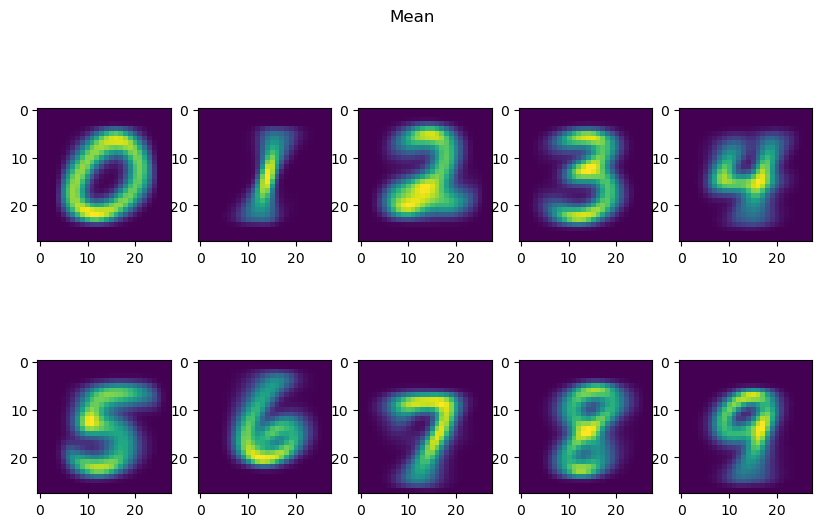

In [87]:
fig, axs = plt.subplots(2,5, figsize=(10,6))
axs = axs.flatten()
for i in range(10):
    vec_mean = np.array(X[y == str(i)]).mean(axis=0)
    img = vec_mean.reshape((28, 28)) 
    axs[i].imshow(img)

# show plot
plt.suptitle('Mean')
plt.show()

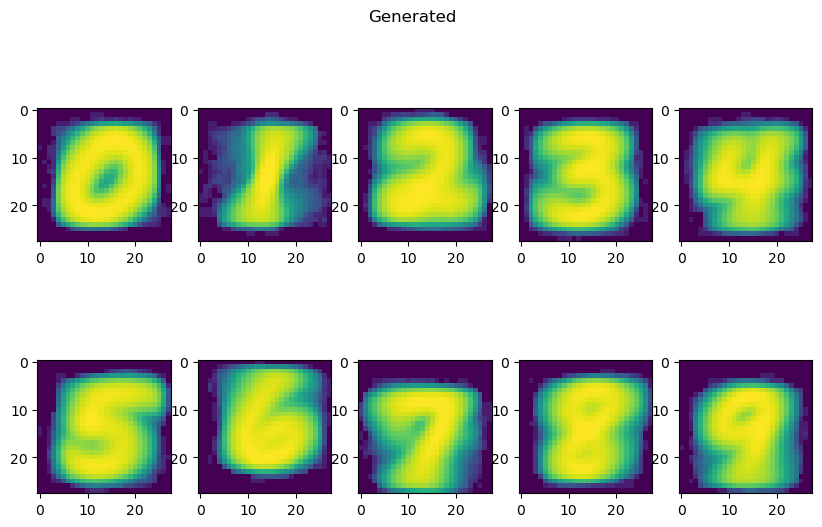

In [88]:
fig, axs = plt.subplots(2,5, figsize=(10,6))
axs = axs.flatten()
for i in range(10):
    vec_mean = clf.feature_log_prob_[i]
    img = vec_mean.reshape((28, 28)) 
    axs[i].imshow(img)
    

# show plot
plt.suptitle('Generated')
plt.show()

##### Plot the confusion matrix of your classifier, as claculated on the test data and Calculate the total accuracy

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       983
           1       0.86      0.96      0.91      1152
           2       0.86      0.83      0.85       967
           3       0.75      0.80      0.78      1034
           4       0.81      0.80      0.80       906
           5       0.82      0.73      0.77       937
           6       0.88      0.89      0.89       961
           7       0.93      0.84      0.89      1055
           8       0.79      0.74      0.77       969
           9       0.74      0.82      0.78      1036

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



c:\Users\yosefos\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


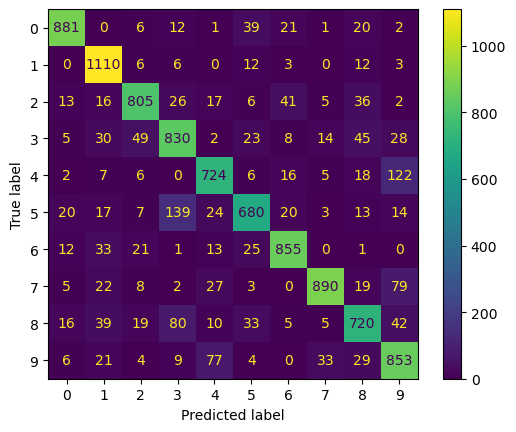

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
print(classification_report(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test);


##### Summarize the results in your own words

Our accuracy is 0.83 which mean, a bit more than 4 out or 5 images are classified correctly.

We can see that some letters have higher accuracy than others.<br>
**0** and **7** have the highest precision 0.92 and 0.93 respectively.

From the confusion matrix plot we can see which numbers are confused with each other more than others, for example:<br>
**4** and **9** are confused with each other.**

We assume the similarity of these shapes creates the confusion.



##### Think of a way you can find the optimal threshold of the binarization part.

A naive approach would be to iterate over all the values train models, predict and see the best scores.

Maybe the binarization can be improved if we use a convolution like method, where we average color values around the neighboring pixels.



## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.



* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`. If there are differences try to think why
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).

### Optional: Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words. 

Bonus: How can you correct the analyzed error? 

To read more about model interpretation, see the blogpost below and my tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

In [90]:
import string
def print_txt(txt, hot, cold):
  """
  print the text, coloring hot and cold words with colors
  """
  cold_color='\x1b[41;37m{}\x1b[0m'
  hot_color='\x1b[42;37m{}\x1b[0m'
  def color(token):
    lower = str(token).lower()
    lower = lower.replace('\t','').replace('\n','')
    lower = lower.translate(string.punctuation)
    if (lower in hot) and (lower in cold):
      return mid_color.format(token)
    elif lower in hot:
      return hot_color.format(token)
    elif lower in cold:
      return cold_color.format(token)
    else:
      return token
  colored_txt = " ".join([color(token) for token in txt.split(' ')])
  print(colored_txt)
print_txt('This word support the first class but this the other', ['word'],['other'])

This word support the first class but this the other


## Data loading


In [91]:
X_train = newsgroups_data_train.data
y_train = newsgroups_data_train.target
X_test = newsgroups_data_test.data
y_test = newsgroups_data_test.target

## Class implementation

In [92]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def fit(self, X, y, alpha=0.5):
        # Determine the number of classes and the total number of samples
        self.num_classes = len(set(y))
        self.num_samples = X.shape[0]
        self.num_features = X.shape[1]
        
        
        # Calculate the class prior probabilities
        self.class_priors = np.log(np.array([np.sum(y == c) / self.num_samples for c in range(self.num_classes)]))
        
        # Calculate the feature probabilities for each class
        feature_probs = []
        for c in range(self.num_classes):
            # Calculate the mean of the feature values for each class
            c_samples = X[y == c] # get all documents labeled c
            word_count = np.sum(c_samples, axis=0) + alpha # count how many times each word appeard in class and add alpha ( applting lidstone smoothing) to each word
            word_count = np.log(word_count/np.sum(word_count)) # apply log to probabilities and normalization
            # Append the feature probabilities for this class to the list
            feature_probs.append(np.array(word_count).flatten()) # flatten because a 2d vector is returned

        # convert to 2d matrix
        self.feature_probs = np.array(feature_probs)
        

        
    
    def predict(self, X):
        # Initialize a list to store the predictions
        y_pred = []

        # Iterate over each sample and predict the class
        for x in X:
            # Convert x from sparse data type to numpy + flatten because it returns 2d vector
            # x = x.toarray().flatten() 
            # Calculate the class scores
            probs = np.sum(x.data * self.feature_probs[:,x.indices],axis=1) + self.class_priors
            y_pred.append(np.argmax(probs))

        return y_pred


## Optimizing CountVectorizer hyperparameters

In [93]:
max_feature = [5000, 10000,50000]
max_df = [0.05,0.1,0.15]

best_feature = 0
best_df = 0
acc_score = 0
for feature in max_feature:
    for df in max_df:
        
        sk_pipe = make_pipeline(CountVectorizer(stop_words='english',max_df=df,max_features=feature), MultinomialNB())
        sk_pipe.fit(X_train,y_train)
        ## Prediction
        score = accuracy_score(sk_pipe.predict(X_test),y_test)
        
        if score > acc_score:
            acc_score = score
            best_df = df
            best_feature = feature

## Data loading , pipeline initialization and prediction calculation

In [94]:


## Pipe line construction

our_pipe = make_pipeline(CountVectorizer(stop_words='english',max_df= best_df,max_features = best_feature), NaiveBayes())
our_pipe.fit(X_train,y_train)
sk_pipe = make_pipeline(CountVectorizer(stop_words='english',max_df= best_df,max_features = best_feature), MultinomialNB())
sk_pipe.fit(X_train,y_train)

## Prediction
y_pred_our = our_pipe.predict(X_test)
y_pred_sklearn = sk_pipe.predict(X_test)

## Classifiction reports

In [95]:
print("Our model classification report")
print(classification_report(y_test,y_pred_our))


Our model classification report
              precision    recall  f1-score   support

           0       0.54      0.50      0.52       319
           1       0.56      0.72      0.63       389
           2       0.50      0.01      0.01       394
           3       0.54      0.73      0.62       392
           4       0.65      0.66      0.66       385
           5       0.68      0.74      0.71       395
           6       0.80      0.73      0.76       390
           7       0.75      0.73      0.74       396
           8       0.82      0.73      0.77       398
           9       0.91      0.80      0.85       397
          10       0.59      0.89      0.71       399
          11       0.70      0.75      0.73       396
          12       0.66      0.54      0.60       393
          13       0.81      0.78      0.79       396
          14       0.75      0.76      0.76       394
          15       0.57      0.84      0.68       398
          16       0.56      0.68      0.62      

In [96]:
print("SKlearn model classification report")
print(classification_report(y_test,y_pred_sklearn))


SKlearn model classification report
              precision    recall  f1-score   support

           0       0.58      0.45      0.51       319
           1       0.57      0.72      0.64       389
           2       0.40      0.01      0.01       394
           3       0.53      0.73      0.61       392
           4       0.68      0.62      0.65       385
           5       0.63      0.78      0.70       395
           6       0.80      0.73      0.77       390
           7       0.77      0.71      0.74       396
           8       0.86      0.68      0.76       398
           9       0.92      0.78      0.85       397
          10       0.58      0.90      0.71       399
          11       0.65      0.77      0.70       396
          12       0.67      0.51      0.58       393
          13       0.81      0.78      0.80       396
          14       0.72      0.77      0.74       394
          15       0.53      0.87      0.66       398
          16       0.56      0.68      0.61  

## Learning Curves - question in the original uploaded HW file

In [97]:
def get_scores(train_scores, test_scores ):    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    return [train_mean, train_std, test_mean, test_std]

def plot_curve(ax,param_range,title, x_label, train_mean, train_std,test_mean,test_std):
    ax.plot(param_range, train_mean, label='train score', color='blue', marker='o')
    ax.fill_between(param_range, train_mean + train_std,
                        train_mean - train_std, color='blue', alpha=0.1)
    ax.plot(param_range, test_mean, label='test score', color='red', marker='o')
    ax.fill_between(param_range, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
    ax.set_title(title)
    ax.grid(ls='--')
    ax.set_xlabel(x_label)
    ax.legend(loc='best')

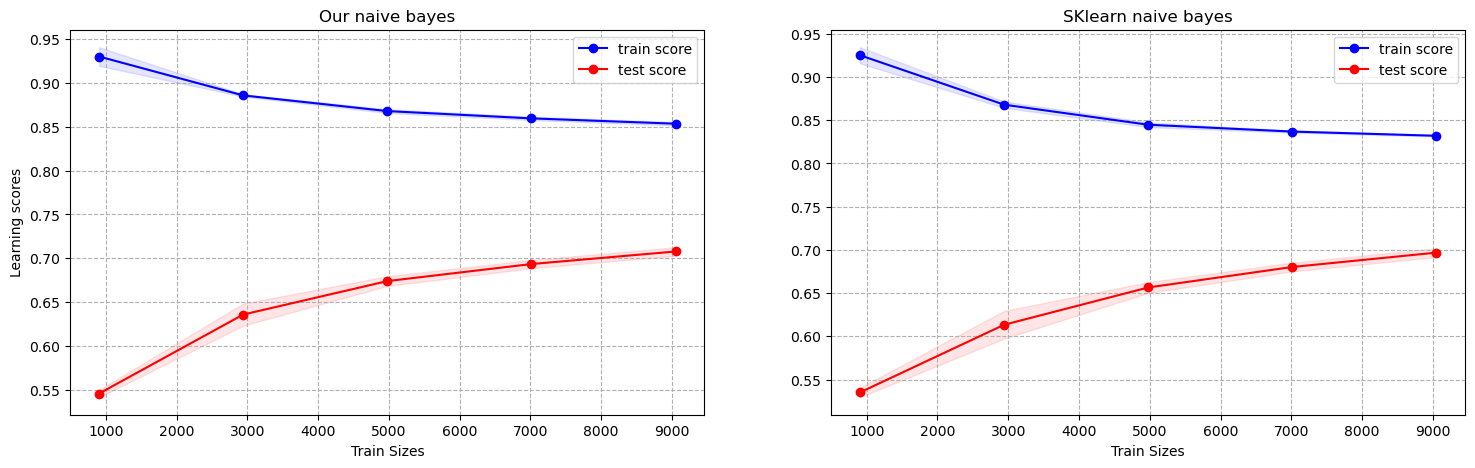

In [98]:
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "n_jobs": 4,
}

fig, axs = plt.subplots(1, 2, figsize=(18,5))
axs[0].set_ylabel('Learning scores')
x_label = 'Train Sizes'


title = 'Our naive bayes'
train_sizes, train_scores, test_scores = learning_curve(our_pipe, **common_params)
sk_train_test_mean_std = get_scores(train_scores, test_scores)
plot_curve(axs[0], train_sizes, title, x_label,  *sk_train_test_mean_std)

title = 'SKlearn naive bayes'
train_sizes, train_scores, test_scores = learning_curve(sk_pipe, **common_params)
our_train_test_mean_std = get_scores(train_scores, test_scores)
plot_curve(axs[1], train_sizes, title, x_label, *our_train_test_mean_std,)

## Results disscussion:

1. The differences between our model and sklearn's are very minor and likely due to different alpha (lidstone smoothing) parameter
2. Since the model has high accuracy on the train score we conclude it is not underfitting, thus the bias is not high. The difference between the train and test is quite significant (15%) and therefor the model is leaning toward the variance region